In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

import tensorflow as tf
# print(tf.test.is_built_with_cuda())
print(tf.config.list_physical_devices('GPU'))



[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1226042006882808289
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4039481753
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16560990571055132363
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1660 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
from pandas import read_csv
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler

import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
mpl.rc('font', family = 'Malgun Gothic') # 그래프 글꼴 설정 (window)

path = 'C:/Users/DMC CONET/saeyun/data/air_weather/'

# df6 = read_csv(path +'df6.csv')
# df6 = df6.drop(columns=['날짜', '6h_PM2.5'])
# df12 = read_csv(path +'df12.csv')
# df12 = df12.drop(columns=['날짜', '6h_PM2.5'])
# df24 = read_csv(path +'df24.csv')
# df24 = df24.drop(columns=['날짜', '6h_PM2.5'])
# target = read_csv(path +'target.csv')


df6 = read_csv(path +'df_train_6.csv')
df6 = df6.drop(columns=['날짜'])
df12 = read_csv(path +'df_train_12.csv')
df12 = df12.drop(columns=['날짜'])
df24 = read_csv(path +'df_train_24.csv')
df24 = df24.drop(columns=['날짜'])
target = read_csv(path +'df_train_target.csv')

print(f'df6.shape : {df6.shape}\ndf12.shape : {df12.shape} \ndf24.shape : {df24.shape} \ntarget.shape : {target.shape}')


df6.shape : (68633, 25)
df12.shape : (68633, 25) 
df24.shape : (68633, 25) 
target.shape : (68633, 1)


In [4]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot

from pandas import read_csv
from pandas import DataFrame
from pandas import concat

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

#from tensorflow.keras import backend
#from keras import backend

In [5]:
df6 =df6[['PM10', 'PM2.5', '오존', '이산화질소', '일산화탄소', '아황산가스', '기온(°C)',
       '강수량(mm)', '풍속(m/s)', '풍향(16방위)', '습도(%)' ]]
df6['변화량'] = df6['PM2.5'] - target['PM2.5']
df12 =df12[['PM10', 'PM2.5', '오존', '이산화질소', '일산화탄소', '아황산가스', '기온(°C)',
       '강수량(mm)', '풍속(m/s)', '풍향(16방위)', '습도(%)' ]]
df12['변화량'] = df12['PM2.5'] - target['PM2.5']
df24 =df24[['PM10', 'PM2.5', '오존', '이산화질소', '일산화탄소', '아황산가스', '기온(°C)',
       '강수량(mm)', '풍속(m/s)', '풍향(16방위)', '습도(%)' ]]
df24['변화량'] = df24['PM2.5'] - target['PM2.5']

In [6]:
# features 정규화
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_6 = scaler.fit_transform(df6)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_12 = scaler.fit_transform(df12)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_24 = scaler.fit_transform(df24)


In [7]:
scaled_6.shape

(68633, 12)

12

In [9]:
x = np.concatenate([scaled_6.reshape((scaled_6.shape[0], 1, scaled_6.shape[1])),\
                    scaled_12.reshape((scaled_6.shape[0], 1, scaled_6.shape[1])),\
                    scaled_24.reshape((scaled_6.shape[0], 1,scaled_6.shape[1]))], axis=1)
x.shape

(68633, 3, 12)

In [10]:
y = target

In [19]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False) #시각화를 위해 shuffle=False 옵션 사용


print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(54906, 3, 12)
(13727, 3, 12)
(54906, 1)
(13727, 1)


In [12]:
model = Sequential()
model.add(LSTM(16, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True)) # , recurrent_dropout=0.2
model.add(LSTM(8))
model.add(Dense(4, activation='relu'))
model.add(Dense(1))

In [ ]:
model = Sequential()
model.add(LSTM(16, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True))
model.add(LSTM(8))
model.add(Dense(4, activation='relu'))
model.add(Dense(1))

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 16)             1856      
                                                                 
 lstm_1 (LSTM)               (None, 8)                 800       
                                                                 
 dense (Dense)               (None, 4)                 36        
                                                                 
 dense_1 (Dense)             (None, 1)                 5         
                                                                 
Total params: 2,697
Trainable params: 2,697
Non-trainable params: 0
_________________________________________________________________


In [17]:
import pandas as pd
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose = 1)

model.compile(loss='mse', optimizer='adam')
EPOCHS = 200

# fit network
# history = model.fit(x, y, epochs=50, batch_size=, verbose=1, validation_split=0.2)

rmse_df = pd.DataFrame()
bat_list = []
rmse_df = []

for i in range(1, 40):
    print(f'{i} 번째 학습 시작합니다.')
    print(f'')
    with tf.device("/device:GPU:0"):
        history = model.fit(x, y,
        epochs = EPOCHS,
        batch_size = i,
        callbacks=[callback],
        validation_split = 0.2)
    y_train_pred = model.predict(x)
    rmse = sqrt(mean_squared_error(y, y_train_pred))
    bat_list.append(i)
    rmse_df.append(rmse)
    print('예측성능 비교지표 RMSE: %.3f' % rmse)
    
    # 훈련 과정 시각화 (손실)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

1 번째 학습 시작합니다.



NameError: name 'X_train' is not defined

Epoch 1/200
54906/54906 [==============================] - 381s 7ms/step - loss: 1.1806 - val_loss: 0.7040
Epoch 2/200
54906/54906 [==============================] - 366s 7ms/step - loss: 0.4075 - val_loss: 1.4795
Epoch 3/200
54906/54906 [==============================] - 365s 7ms/step - loss: 0.2794 - val_loss: 0.3733
Epoch 4/200
54906/54906 [==============================] - 378s 7ms/step - loss: 0.2232 - val_loss: 0.3537
Epoch 5/200
54906/54906 [==============================] - 358s 7ms/step - loss: 0.1939 - val_loss: 0.3127
Epoch 6/200
54906/54906 [==============================] - 350s 6ms/step - loss: 0.1731 - val_loss: 0.1043
Epoch 7/200
54906/54906 [==============================] - 374s 7ms/step - loss: 0.1513 - val_loss: 0.2240
Epoch 8/200
54906/54906 [==============================] - 356s 6ms/step - loss: 0.1367 - val_loss: 0.1261
Epoch 9/200
54906/54906 [==============================] - 365s 7ms/step - loss: 0.1234 - val_loss: 0.1396
Epoch 10/200
54906/54906 [===========

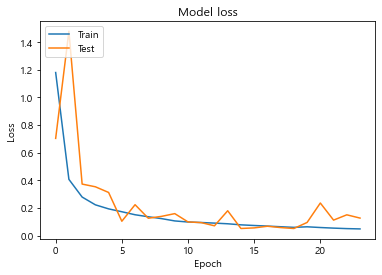

In [20]:
import pandas as pd
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose = 1)

model.compile(loss='mse', optimizer='adam')
EPOCHS = 200

# fit network
# history = model.fit(x, y, epochs=50, batch_size=, verbose=1, validation_split=0.2)

rmse_df = pd.DataFrame()
bat_list = []
rmse_df = []

with tf.device("/device:GPU:0"):
    history = model.fit(x_train, y_train,
    epochs = EPOCHS,
    batch_size = 1,
    callbacks=[callback],
    validation_split = 0.2,
    validation_data=[x_test, y_test])

429/429 [==============================] - 1s 3ms/step
예측성능 비교지표 RMSE: 0.357
r2_score : 0.9994518232504404



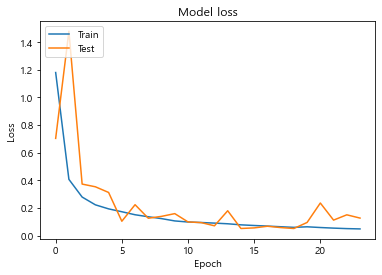

In [22]:
y_test_pred = model.predict(x_test)
from sklearn.metrics import r2_score
rmse = sqrt(mean_squared_error(y_test, y_test_pred))
bat_list.append(i)
rmse_df.append(rmse)
print('예측성능 비교지표 RMSE: %.3f' % rmse)
print(f'r2_score : {r2_score(y_test, y_test_pred)}\n')
# 훈련 과정 시각화 (손실)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import r2_score


In [24]:
# RMSE(Root Mean Square Error) 계산
# https://artwook.tistory.com/152
# https://blog.naver.com/jaysrogers/2



# https://www.statisticshowto.com/probability-and-statistics/regression-analysis/rmse-root-mean-square-error/

y_train_pred = model.predict(x)
rmse = sqrt(mean_squared_error(y, y_train_pred))
print('예측성능 비교지표 RMSE: %.3f' % rmse)   
print('예측성능 비교지표 RMSE: %.3f' % rmse)   


2145/2145 [==============================] - 8s 3ms/step
예측성능 비교지표 RMSE: 8.889


In [ ]:
from pandas import read_csv
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler

import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
mpl.rc('font', family = 'Malgun Gothic') # 그래프 글꼴 설정 (window)

path = 'C:/Users/DMC CONET/saeyun/data/air_weather/'

# df6 = read_csv(path +'df6.csv')
# df6 = df6.drop(columns=['날짜', '6h_PM2.5'])
# df12 = read_csv(path +'df12.csv')
# df12 = df12.drop(columns=['날짜', '6h_PM2.5'])
# df24 = read_csv(path +'df24.csv')
# df24 = df24.drop(columns=['날짜', '6h_PM2.5'])
# target = read_csv(path +'target.csv')


df6_test = read_csv(path +'df_test_6.csv')
# df6_test = df6.drop(columns=['날짜'])
df12_test = read_csv(path +'df_test_12.csv')
# df12_test = df12.drop(columns=['날짜'])
df24_test = read_csv(path +'df_test_24.csv')
# df24_test = df24.drop(columns=['날짜'])
target_test = read_csv(path +'df_test_target.csv')

print(f'df6.shape : {df6.shape}\ndf12.shape : {df12.shape} \ndf24.shape : {df24.shape} \ntarget.shape : {target.shape}')


In [ ]:
df6 =df6_test[['PM10', 'PM2.5', '오존', '이산화질소', '일산화탄소', '아황산가스', '기온(°C)',
       '강수량(mm)', '풍속(m/s)', '풍향(16방위)', '습도(%)' ]]
df12 =df12_test[['PM10', 'PM2.5', '오존', '이산화질소', '일산화탄소', '아황산가스', '기온(°C)',
       '강수량(mm)', '풍속(m/s)', '풍향(16방위)', '습도(%)' ]]
df24 =df24_test[['PM10', 'PM2.5', '오존', '이산화질소', '일산화탄소', '아황산가스', '기온(°C)',
       '강수량(mm)', '풍속(m/s)', '풍향(16방위)', '습도(%)' ]]

In [ ]:
# features 정규화
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_6 = scaler.fit_transform(df6)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_12 = scaler.fit_transform(df12)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_24 = scaler.fit_transform(df24)
y = target

In [ ]:
x = np.concatenate([scaled_6.reshape((scaled_6.shape[0], 1, scaled_6.shape[1])),\
                    scaled_12.reshape((scaled_6.shape[0], 1, scaled_6.shape[1])),\
                    scaled_24.reshape((scaled_6.shape[0], 1,scaled_6.shape[1]))], axis=1)
x.shape

In [ ]:
y_test_pred = model.predict(x)

In [ ]:
import pandas as pd

In [ ]:
result = pd.DataFrame(y_test_pred, columns=['predict'])
result['answer'] = y
result['날짜'] = df6_test['날짜']

result = result[['날짜', 'predict', 'answer']]

plt.figure(figsize=(50, 15))
plt.plot(result['answer'], color='red')
plt.plot(result['predict'], color='blue')
plt.show()


# 2.5, 6_2.5 차이를 목표변수로 설정

In [ ]:
# RMSE(Root Mean Square Error) 계산
# https://artwook.tistory.com/152
# https://blog.naver.com/jaysrogers/221737694744
# https://www.statisticshowto.com/probability-and-statistics/regression-analysis/rmse-root-mean-square-error/

y_train_pred = model.predict(x)
rmse = sqrt(mean_squared_error(y, y_test_pred))
print('예측성능 비교지표 RMSE: %.3f' % rmse)   


In [ ]:
history.history

In [ ]:
# # 6 훈련 과정 시각화 (정확도)
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('Model accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend(['Train', 'Test'], loc='upper left')
# plt.show()

# 훈련 과정 시각화 (손실)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# TEST

In [ ]:
pd.